# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Business Understanding

## Background
Startbucks is a retailer of coffee and related brews. They have, over the years, become the go-to place for avid coffe drinkers. The Starbucks brand has, in recent years, spread outside the borders of the U.S.A. and is now world renowned for its quality coffee.

## Business goals
Starbiucks would like to get more of their customers onto their app. The users of the Starbucks app gain access to the current offers than the Starbucks brand is promoting. Startbucks would like to get an idea of which ckients would respond to which type of offers, based on the clients demographics.


In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.shape

(10, 6)

# 2. Data Understanding

Let's get to undestand the data we have at our disposal. We have three datasets: portfolio, profile and transcript.

## Profile Dataset

Lets look at the profile dataset.

In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
user_count=profile.shape[0]
user_count

17000

The profile dataset contains members of the rewards program. From the data we can see that some of the members did not supply all of the information to fill all the dataset features. 

### Members Who Did Not Supply Information
We extract the users how did not provide information about themselves.

In [5]:
profile_no_info=profile[((profile['gender'].isnull()) &(profile['income'].isnull()) & (profile['age']==118))]


In [6]:


(profile_no_info.shape[0]/user_count)*100

12.794117647058822

For the purposes of data understanding, we will remove the users without and any gender, income and age data.

In [7]:
profile=profile[~((profile['gender'].isnull()) &(profile['income'].isnull()) & (profile['age']==118))]


Replace empty age value with mean age of the entire population.

In [8]:
mean_age=math.ceil(profile.age.mean())

profile.replace({'age':118}, mean_age,inplace=True)

Replace the NaN income value withe mean income of the population

In [9]:
mean_income=math.ceil(profile.income.mean())
profile.replace({'income':np.NaN},mean_income,inplace=True)

In [10]:
profile.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [11]:
bins = pd.IntervalIndex.from_tuples([(10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80),(80, 90), (90, 100),(100,120)])
profile['age_group']=pd.cut(profile.age,bins)

In [12]:
profile[['income']].describe()

,income
count,14825.000000
mean,65404.991568
std,21598.299410
min,30000.000000
25%,49000.000000
50%,64000.000000
75%,80000.000000
max,120000.000000


Let's make the new age_group values more readable.

In [13]:
profile['age_group']=profile['age_group'].map(lambda x: str(x).replace('(','').replace(', ','_to_').replace(']',''))

In [14]:
profile.head()

,age,became_member_on,gender,id,income,age_group
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,50_to_60
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,70_to_80
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,60_to_70
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,60_to_70
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,50_to_60


#### Age Insight
Let's see whatthe age breakdown of the members is.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ad550b8>]],
      dtype=object)

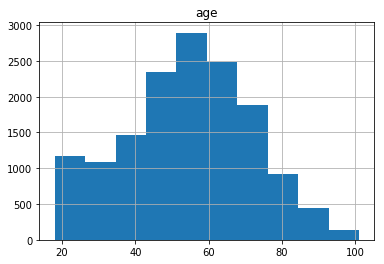

In [15]:
profile[['age']].hist()

We can see from the histogram above the age of members is concentrated around the ages from about 35 to about 75.

### Income Per Age Group

Lets get an undestanding the income per age group. This will give us insight as to which group has a the highest/lowest income.

In [16]:
mean_income_by_age_group=profile.groupby('age_group')['income'].mean().to_frame()


In [17]:
mean_income_by_age_group=mean_income_by_age_group.reset_index()

In [18]:
mean_income_by_age_group.describe()

,income
count,10.000000
mean,64113.597096
std,8745.918435
min,50458.823529
25%,56688.000386
50%,68968.728522
75%,70568.779450
max,72176.010430


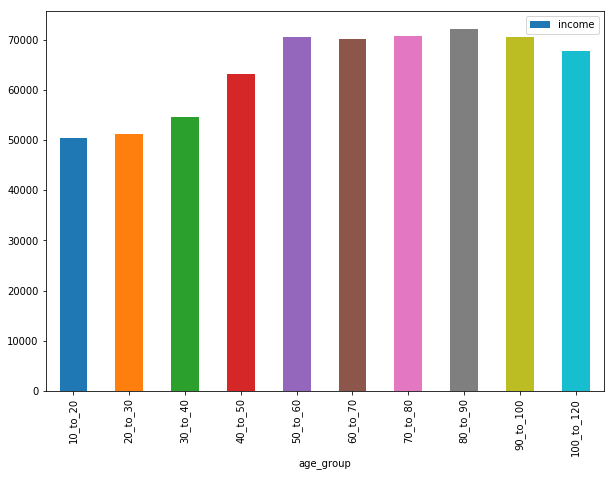

In [19]:
mean_income_by_age_group.plot.bar(x='age_group',y='income',figsize=(10,7))





What the graph above shows us is that the age groups above 50 are the highest earners on average.

### Gender Split
Let's get an understanding of a gender split among the participants.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11afe9e80>],
      dtype=object)

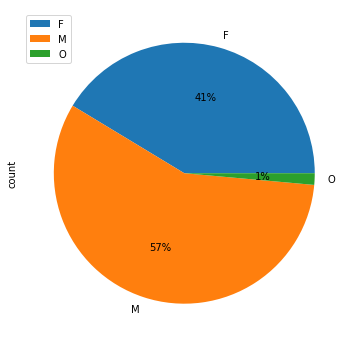

In [20]:
gender_split=profile.groupby(['gender'])['id'].count().reset_index()
gender_split.rename(index=str, columns={"id":"count"},inplace=True)
gender_split=gender_split.set_index('gender')
gender_split.plot.pie(subplots=True, figsize=(12, 6),autopct='%1.0f%%')

From the graph above we can we that the majority (57%) of the people on the Starbucks app are male. And only 41% are female.

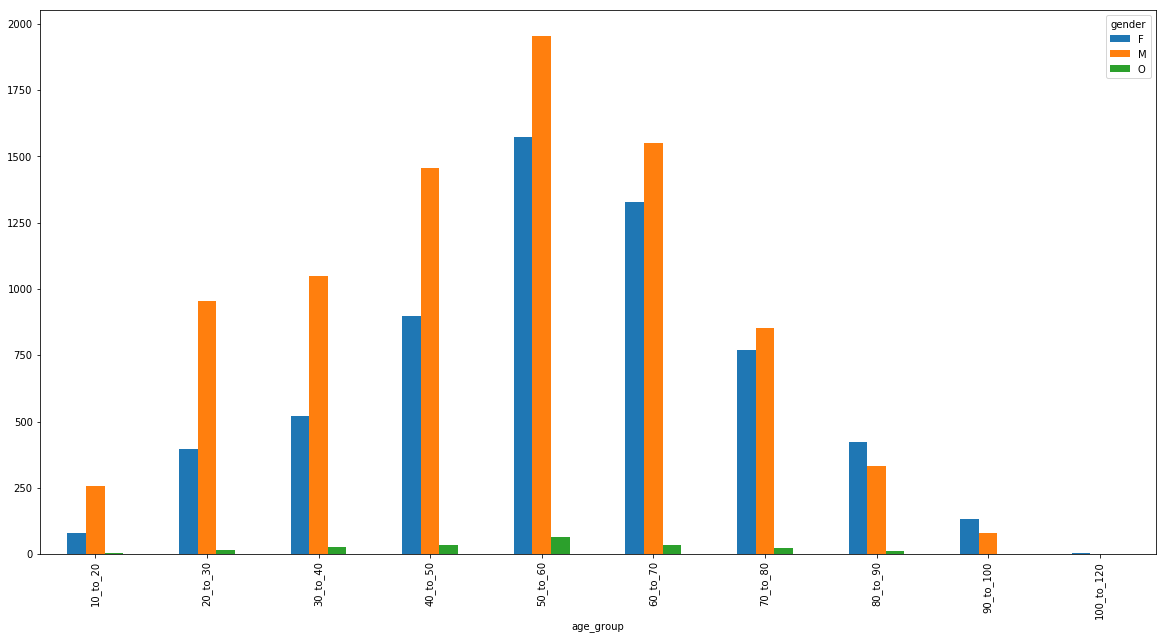

In [21]:
gender_age_split=profile.groupby(['gender','age_group'])['id'].count().reset_index()
gender_age_split.rename(index=str, columns={"id":"count"},inplace=True)
gender_age_split=gender_age_split.set_index('age_group')
gender_age_split=gender_age_split.pivot_table('count',['age_group'],'gender')
gender_age_split=gender_age_split.fillna(0)
gender_age_split.plot.bar(figsize=(20, 10))

From the graph above, we can see that the 50 to 60 age group has the highest number of participants. Also, we can see that males are the highest all age groups expect for the age groups above than 80 years.

In [22]:
#gender_age_split[gender_age_split['gender']=='F'].plot.bar(x='age_group',y='count')
#gender_age_split[gender_age_split['gender']=='M'].plot.bar(x='age_group',y='count')
#gender_age_split[gender_age_split['gender']=='O'].plot.bar(x='age_group',y='count')


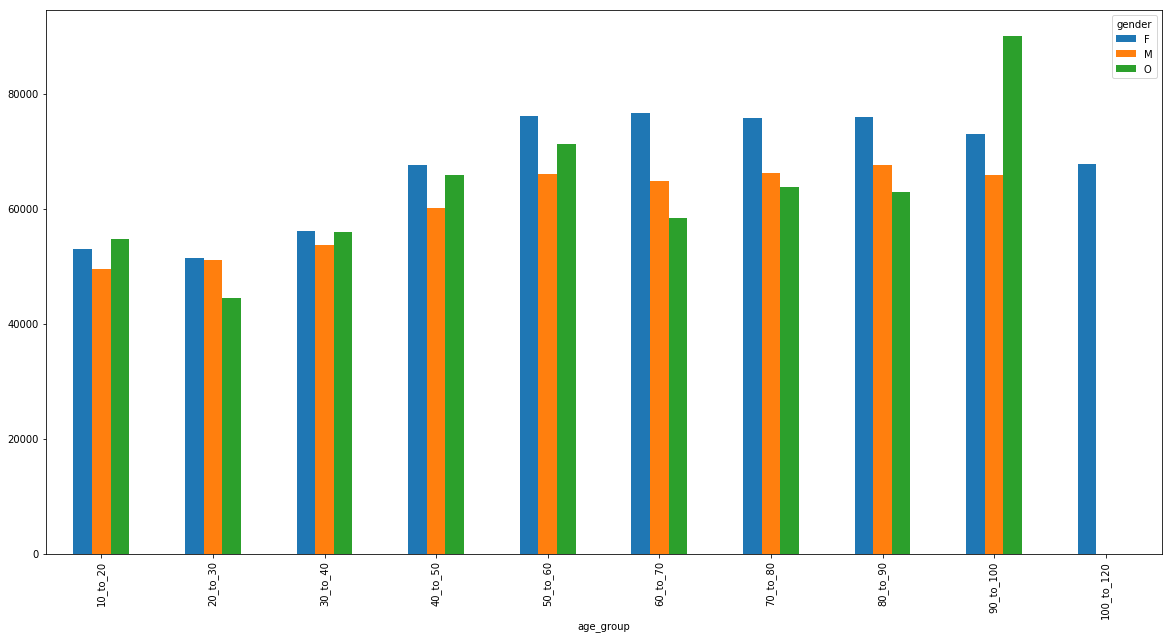

In [23]:
gender_age_income=profile.groupby(['gender','age_group'])['income'].mean().reset_index()
gender_age_income=gender_age_income.set_index('age_group')
gender_age_income=gender_age_income.pivot_table('income',['age_group'],'gender')
gender_age_income=gender_age_income.fillna(0)
gender_age_income.plot.bar(figsize=(20, 10))

The graph above reveals that across all the age groups, the females on earn higher than males on average. This is quite an interesting an unexpected find given the much talked about gender-pay gap which is supposed to favour the male gender.

### Transcipt Dataset

Lets look at the transcipt dataset and see what insight we can get from it.

In [24]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


The value field looks like if contains json data. The data seems to contains offer id information. The function below will extract the offer id from the value field. This function will come handy once we have explored the data further.

In [25]:
def stripValueToOfferId(df):
    """
    Args:
    df : DataFrame the dataframe to be updated
    """
    for index,row in df.iterrows():
        df.set_value(index,'offer_id',row['value']['offer id'])
    df.drop(columns=['value'],inplace=True)
    
def stripValueToOfferIdReward(df):
    """
    Args:
    df : DataFrame the dataframe to be updated
    """
    for index,row in df.iterrows():
        df.set_value(index,'offer_id',row['value']['offer id'])
        df.set_value(index,'reward',row['value']['reward'])
    df.drop(columns=['value','event'],inplace=True)

It looks like like dataset containns information about different events memebers execute on the app. We will now group the dataset to see how many event types exist and the counts thereof.

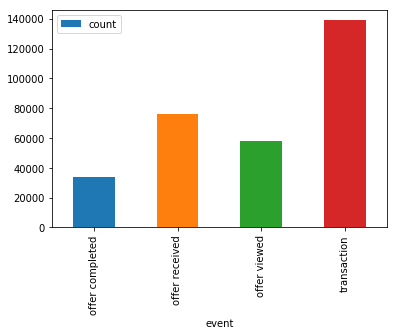

In [26]:
event_count=transcript.groupby('event')['person'].count().reset_index()
event_count.rename(index=str, columns={"person":"count"},inplace=True)
event_count.plot.bar(x='event',y='count')

From the bar chart above we can see that we have 4 types of events: offer completed, offer received, offer viewed and transaction. We now explore this dataset further by extracting the individual event types to separate dataframes. 

In [27]:
g=transcript.groupby('event')
offer_completed=g.get_group('offer completed')
offer_received=g.get_group('offer received')
offer_viewed=g.get_group('offer viewed')
transaction=g.get_group('transaction')

#### Offer Completed Dataset
##### Event
Since all the values in the event column in the offer_completed dataset, lets drop this column.

In [28]:
offer_completed.drop(columns=['event'],inplace=True)
offer_completed.head()

/Users/MX/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,person,time,value
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


##### Value field

Let's extract the offer id and reword from the value field to new offer_id and reward fields. We will then drop the the value field.

In [29]:
offer_completed['offer_id']=offer_completed['value'].map(lambda x: x['offer_id'] if isinstance(x,dict) else np.NaN)
offer_completed['reward']=offer_completed['value'].map(lambda x: x['reward'] if isinstance(x,dict) else np.NaN)
offer_completed.drop(columns=['value'],inplace=True)
offer_completed.head()

/Users/MX/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/MX/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,person,time,offer_id,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,2
12672,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,2
12679,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
12692,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,10
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10


#### Offer Received Dataset

We will also remove the event and extract the offer_id field from the value field, just like we did above except here we have no reward field.

In [30]:
offer_received.drop(columns=['event'],inplace=True)
offer_received['offer_id']=offer_received['value'].map(lambda x: x['offer id'] if isinstance(x,dict) else np.NaN)
offer_received.drop(columns=['value'],inplace=True)
offer_received.head()


/Users/MX/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,person,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0


#### Offer Viewed Dataset
We will also remove the event and extract the offer_id field from the value field, just like we did above except here we have no reward field.


In [31]:
offer_viewed.drop(columns=['event'],inplace=True)
offer_viewed['offer_id']=offer_viewed['value'].map(lambda x: x['offer id'] if isinstance(x,dict) else np.NaN)
offer_viewed.drop(columns=['value'],inplace=True)
offer_viewed.head()

/Users/MX/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,person,time,offer_id
12650,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
12651,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837
12652,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd
12655,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837


#### Transaction Dataset

This dataset contains transaction data for each member. This is the data related to how much each member has spent.

We will drop the event field and extract the amount field from the value field.

In [32]:
transaction.head()
transaction.drop(columns=['event'],inplace=True)
transaction['amount']=transaction['value'].map(lambda x: x['amount'] if isinstance(x,dict) else np.NaN)
transaction.drop(columns=['value'],inplace=True)
transaction.head()

/Users/MX/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,person,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [33]:
transaction.head()

,person,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


##### Total Spend Per Person 
Let's look at the total spend per person.

In [34]:
total_spend_per_person=transaction.groupby('person')['amount'].sum().reset_index()
total_spend_per_person.head()

,person,amount
0,0009655768c64bdeb2e877511632db8f,127.60
1,00116118485d4dfda04fdbaba9a87b5c,4.09
2,0011e0d4e6b944f998e987f904e8c1e5,79.46
3,0020c2b971eb4e9188eac86d93036a77,196.86
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11af52160>]],
      dtype=object)

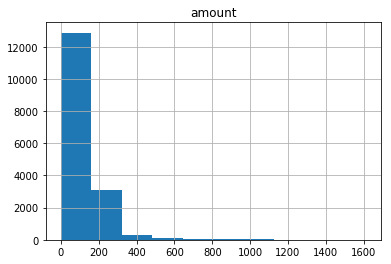

In [35]:
total_spend_per_person.hist()

From the graph above we can we that the vast majority of members spend is just below $200. 

###### Transactions
Transaction dataset transactions performed by each member. We will just sum up the transaction amounts per member.

In [36]:
transaction.head()

,person,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [37]:
transaction=transaction.groupby('person')['amount'].sum().reset_index()
transaction=transaction.set_index('person')

In [38]:
transaction.head()

,amount
person,
0009655768c64bdeb2e877511632db8f,127.60
00116118485d4dfda04fdbaba9a87b5c,4.09
0011e0d4e6b944f998e987f904e8c1e5,79.46
0020c2b971eb4e9188eac86d93036a77,196.86
0020ccbbb6d84e358d3414a3ff76cffd,154.05


## Portfolio Dataset

The porfolio dataset contains different types of offers offered by Starbucks. These are sent via different channels as specified in the channels column as depicted in the table below: 

In [39]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


### Channel field

To extract the deifferent channels, we will create new columns for types of channels. The code below will help us achieve this.

In [40]:
channels=[]
for index,row in portfolio.iterrows():
    for channel in row['channels']:
        channels.append(channel)
    
    
channels=list(set(channels))
for channel in channels:
    portfolio[channel]=portfolio['channels'].map(lambda x: 1 if channel in x else 0 )
portfolio.drop(columns=['channels'],inplace=True)
portfolio

,difficulty,duration,id,offer_type,reward,web,email,social,mobile
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


### More portfolio insight

Let's combine teh portfolio data with profile data above and see if we can gain some more insight.

In [41]:

offer_view_count=offer_viewed.groupby('offer_id')['person'].count().reset_index()
offer_view_count.rename(index=str, columns={'person':'view_count'},inplace=True)
offer_view_count=offer_view_count.set_index('offer_id')
offer_view_count

,view_count
offer_id,
0b1e1539f2cc45b7b9fa7c272da2e1d7,2663
2298d6c36e964ae4a3e7e9706d1fb8c2,7337
2906b810c7d4411798c6938adc9daaa5,4118
3f207df678b143eea3cee63160fa8bed,4144
4d5c57ea9a6940dd891ad53e9dbe8da0,7298
5a8bc65990b245e5a138643cd4eb9837,6687
9b98b8c7a33c4b65b9aebfe6a799e6d9,4171
ae264e3637204a6fb9bb56bc8210ddfd,6716
f19421c1d4aa40978ebb69ca19b0e20d,7264


In [42]:
offer_received_count=offer_received.groupby('offer_id')['person'].count().reset_index()
offer_received_count.rename(index=str, columns={'person':'received_count'},inplace=True)
offer_received_count=offer_received_count.set_index('offer_id')
offer_received_count

,received_count
offer_id,
0b1e1539f2cc45b7b9fa7c272da2e1d7,7668
2298d6c36e964ae4a3e7e9706d1fb8c2,7646
2906b810c7d4411798c6938adc9daaa5,7632
3f207df678b143eea3cee63160fa8bed,7617
4d5c57ea9a6940dd891ad53e9dbe8da0,7593
5a8bc65990b245e5a138643cd4eb9837,7618
9b98b8c7a33c4b65b9aebfe6a799e6d9,7677
ae264e3637204a6fb9bb56bc8210ddfd,7658
f19421c1d4aa40978ebb69ca19b0e20d,7571


In [43]:
offer_completed_count=offer_completed.groupby(['offer_id'])['person'].count().reset_index()
offer_completed_count.rename(index=str, columns={'person':'completed_count'},inplace=True)
offer_completed_count=offer_completed_count.set_index('offer_id')
offer_completed_count

,completed_count
offer_id,
0b1e1539f2cc45b7b9fa7c272da2e1d7,3420
2298d6c36e964ae4a3e7e9706d1fb8c2,5156
2906b810c7d4411798c6938adc9daaa5,4017
4d5c57ea9a6940dd891ad53e9dbe8da0,3331
9b98b8c7a33c4b65b9aebfe6a799e6d9,4354
ae264e3637204a6fb9bb56bc8210ddfd,3688
f19421c1d4aa40978ebb69ca19b0e20d,4296
fafdcd668e3743c1bb461111dcafc2a4,5317


In [44]:
portfolio.rename(index=str, columns={'id':'offer_id'},inplace=True)

In [45]:
portfolio.set_index('offer_id')

,difficulty,duration,offer_type,reward,web,email,social,mobile
offer_id,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,7,bogo,10,0,1,1,1
4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,bogo,10,1,1,1,1
3f207df678b143eea3cee63160fa8bed,0,4,informational,0,1,1,0,1
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,0,1
0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,1,0,0
2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,discount,3,1,1,1,1
fafdcd668e3743c1bb461111dcafc2a4,10,10,discount,2,1,1,1,1
5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,0,1,1,1
f19421c1d4aa40978ebb69ca19b0e20d,5,5,bogo,5,1,1,1,1


In [46]:
offer_received_count

,received_count
offer_id,
0b1e1539f2cc45b7b9fa7c272da2e1d7,7668
2298d6c36e964ae4a3e7e9706d1fb8c2,7646
2906b810c7d4411798c6938adc9daaa5,7632
3f207df678b143eea3cee63160fa8bed,7617
4d5c57ea9a6940dd891ad53e9dbe8da0,7593
5a8bc65990b245e5a138643cd4eb9837,7618
9b98b8c7a33c4b65b9aebfe6a799e6d9,7677
ae264e3637204a6fb9bb56bc8210ddfd,7658
f19421c1d4aa40978ebb69ca19b0e20d,7571


In [47]:
portfolio_response_counts=portfolio.join(offer_completed_count, on='offer_id',how='outer').join(offer_view_count, on='offer_id',how='outer').join(offer_received_count, on='offer_id',how='outer')

Let's convert the **view_count** field to a percentage of the **received_count**. 

In [48]:
portfolio_response_counts['view_count']=portfolio_response_counts['view_count']/portfolio_response_counts['received_count']

Let's convert the **completed_count** field to a percentage of the **received_count**. 

In [49]:
portfolio_response_counts['completed_count']=portfolio_response_counts['completed_count']/portfolio_response_counts['received_count']

In [50]:
portfolio_response_counts

,difficulty,duration,offer_id,offer_type,reward,web,email,social,mobile,completed_count,view_count,received_count
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,0.481588,0.876991,7658
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,0.438694,0.961148,7593
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,NaN,0.544046,7617
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,0.567149,0.543311,7677
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0,0.446009,0.347287,7668
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,0.674340,0.959587,7646
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,0.699882,0.964460,7597
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1,NaN,0.877789,7618
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,0.567428,0.959451,7571
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,0.526336,0.539570,7632


##### Informational Offers

Based on the table above, it's clear and not surprising that the informational offers do not have the completed count field. We can assume that viewing an informational offer is completing the offer. For the purpose of analying the offer data, we shall ignore the informational offers.

In [51]:
portfolio_response_counts=portfolio_response_counts[portfolio_response_counts['offer_type']!='informational']
portfolio_response_counts

,difficulty,duration,offer_id,offer_type,reward,web,email,social,mobile,completed_count,view_count,received_count
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,0.481588,0.876991,7658
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,0.438694,0.961148,7593
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,0.567149,0.543311,7677
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0,0.446009,0.347287,7668
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,0.674340,0.959587,7646
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,0.699882,0.964460,7597
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,0.567428,0.959451,7571
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,0.526336,0.539570,7632


Let's see response by offer type.

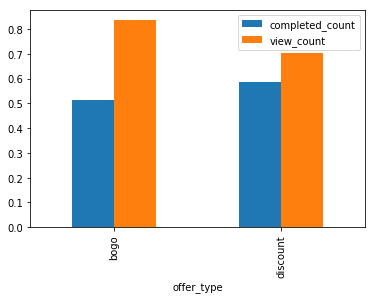

In [52]:
portfolio_response_counts.groupby('offer_type')['completed_count','view_count'].mean().reset_index().plot.bar(x='offer_type',y=['completed_count','view_count'])

By One Get One offers are viewed more than discount offers. Just over 80% of bogo offers are viewed as compared to about 70% of discount offers. Interistingly, only 50% of bogo offers are completed as comapred to about 60% of discount offers.

# 3. Data Preparation

Now that we an understanding of what is in our datasets, we will now prepare the data modeling.
## 3.1 Portfolio

### Offer Type
The offer type field is categorical, we will need to one-hot encode it.

In [53]:
portfolio=pd.get_dummies(portfolio,prefix=['offer_type'],columns=['offer_type'])
portfolio.head()

,difficulty,duration,offer_id,reward,web,email,social,mobile,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


### Offer Id

The **offer_id** field seems to be a unique identifier, so let's make that our index.

In [54]:
portfolio=portfolio.set_index('offer_id')
portfolio

,difficulty,duration,reward,web,email,social,mobile,offer_type_bogo,offer_type_discount,offer_type_informational
offer_id,,,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,0,1,1,1,1,0,0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,1,0,0
3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,0,1,0,0,1
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,0,1,1,0,0
0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,1,0,0,0,1,0
2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,1,1,1,1,0,1,0
fafdcd668e3743c1bb461111dcafc2a4,10,10,2,1,1,1,1,0,1,0
5a8bc65990b245e5a138643cd4eb9837,0,3,0,0,1,1,1,0,0,1
f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0


## 3.2 Profile
#### Age Group

The age group field is categorical, let's one-hot encode this.

In [55]:
profile=pd.get_dummies(profile,prefix=['age_group'],columns=['age_group'])

#### Gender

The gender field is also categorical, this too will be one-hot encoded.

In [56]:
profile=pd.get_dummies(profile,prefix=['gender'],columns=['gender'])

#### Id

Let's make the id field the index of this dataset.

In [57]:
profile=profile.set_index('id')

#### became member on

We will use this field to engineer a new **years_active** field. We will then drop the **became_member_on** field.

In [58]:
from datetime import datetime

today = datetime.now()
profile['years_active']=profile['became_member_on'].map(lambda x : today.year-datetime.strptime(str(int(x)),"%Y%m%d").year )
profile.drop(columns=['became_member_on'],inplace=True)
profile.head()

,age,income,age_group_10_to_20,age_group_20_to_30,age_group_30_to_40,age_group_40_to_50,age_group_50_to_60,age_group_60_to_70,age_group_70_to_80,age_group_80_to_90,age_group_90_to_100,age_group_100_to_120,gender_F,gender_M,gender_O,years_active
id,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,55,112000.0,0,0,0,0,1,0,0,0,0,0,1,0,0,2
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,0,0,0,0,0,0,1,0,0,0,1,0,0,2
e2127556f4f64592b11af22de27a7932,68,70000.0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
389bc3fa690240e798340f5a15918d5c,65,53000.0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,2


Finally we'll check if there are any NaN values.

In [59]:
profile.isnull().values.any()

False

## 3.3 Combining dataset

In [60]:
offer_received=offer_received.set_index('person')
offer_received.head()

,time,offer_id
person,,
78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0


Merge offer_received with the profile dataset into a new **main_df** dataframe.

In [61]:

main_df=offer_received.join(profile)
main_df.head()


,time,offer_id,age,income,age_group_10_to_20,age_group_20_to_30,age_group_30_to_40,age_group_40_to_50,age_group_50_to_60,age_group_60_to_70,age_group_70_to_80,age_group_80_to_90,age_group_90_to_100,age_group_100_to_120,gender_F,gender_M,gender_O,years_active
0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,33.0,72000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,33.0,72000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,33.0,72000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,33.0,72000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,33.0,72000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0


Add portfolio attributes to the **main_df** dataset.

In [62]:
main_df=main_df.join(portfolio,on='offer_id',how='inner')

main_df.head()




,time,offer_id,age,income,age_group_10_to_20,age_group_20_to_30,age_group_30_to_40,age_group_40_to_50,age_group_50_to_60,age_group_60_to_70,...,difficulty,duration,reward,web,email,social,mobile,offer_type_bogo,offer_type_discount,offer_type_informational
0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,33.0,72000.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,3,0,0,1,1,1,0,0,1
0011e0d4e6b944f998e987f904e8c1e5,336,5a8bc65990b245e5a138643cd4eb9837,40.0,57000.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,3,0,0,1,1,1,0,0,1
0020c2b971eb4e9188eac86d93036a77,504,5a8bc65990b245e5a138643cd4eb9837,59.0,90000.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,3,0,0,1,1,1,0,0,1
0020ccbbb6d84e358d3414a3ff76cffd,408,5a8bc65990b245e5a138643cd4eb9837,24.0,60000.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,3,0,0,1,1,1,0,0,1
003d66b6608740288d6cc97a6903f4f0,0,5a8bc65990b245e5a138643cd4eb9837,26.0,73000.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,3,0,0,1,1,1,0,0,1


In [63]:
main_df.index.names=['person']


We will merge the main dataframe with the complted offers dataframe so that we can get an overall picture of members who complete offers.

In [64]:
main_df=pd.merge(main_df,offer_completed,suffixes=('_original','_complete'),how='left',left_on=['person','offer_id'],right_on=['person','offer_id'])

main_df.head()

,person,time_original,offer_id,age,income,age_group_10_to_20,age_group_20_to_30,age_group_30_to_40,age_group_40_to_50,age_group_50_to_60,...,reward_original,web,email,social,mobile,offer_type_bogo,offer_type_discount,offer_type_informational,time_complete,reward_complete
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,33.0,72000.0,0.0,0.0,1.0,0.0,0.0,...,0,0,1,1,1,0,0,1,NaN,NaN
1,0011e0d4e6b944f998e987f904e8c1e5,336,5a8bc65990b245e5a138643cd4eb9837,40.0,57000.0,0.0,0.0,1.0,0.0,0.0,...,0,0,1,1,1,0,0,1,NaN,NaN
2,0020c2b971eb4e9188eac86d93036a77,504,5a8bc65990b245e5a138643cd4eb9837,59.0,90000.0,0.0,0.0,0.0,0.0,1.0,...,0,0,1,1,1,0,0,1,NaN,NaN
3,0020ccbbb6d84e358d3414a3ff76cffd,408,5a8bc65990b245e5a138643cd4eb9837,24.0,60000.0,0.0,1.0,0.0,0.0,0.0,...,0,0,1,1,1,0,0,1,NaN,NaN
4,003d66b6608740288d6cc97a6903f4f0,0,5a8bc65990b245e5a138643cd4eb9837,26.0,73000.0,0.0,1.0,0.0,0.0,0.0,...,0,0,1,1,1,0,0,1,NaN,NaN


Let's remove unnecessary fields

In [65]:

main_df.drop(['time_complete','time_original'], axis=1,inplace=True)


We'll rename the **reward_complete** field to **completed**, this will hold a flag to indicate where the offer was completed or not.

In [66]:
main_df.rename(index=str,columns={'reward_complete':'completed'},inplace=True)
main_df

,person,offer_id,age,income,age_group_10_to_20,age_group_20_to_30,age_group_30_to_40,age_group_40_to_50,age_group_50_to_60,age_group_60_to_70,...,duration,reward_original,web,email,social,mobile,offer_type_bogo,offer_type_discount,offer_type_informational,completed
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,33.0,72000.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,NaN
1,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,40.0,57000.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,NaN
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,59.0,90000.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3,0,0,1,1,1,0,0,1,NaN
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,24.0,60000.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,NaN
4,003d66b6608740288d6cc97a6903f4f0,5a8bc65990b245e5a138643cd4eb9837,26.0,73000.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,NaN
5,00426fe3ffde4c6b9cb9ad6d077a13ea,5a8bc65990b245e5a138643cd4eb9837,19.0,65000.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,NaN
6,0063def0f9c14bc4805322a488839b32,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,0,0,1,1,1,0,0,1,NaN
7,0082fd87c18f45f2be70dbcbb0fb8aad,5a8bc65990b245e5a138643cd4eb9837,28.0,68000.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,NaN
8,008d7088107b468893889da0ede0df5c,5a8bc65990b245e5a138643cd4eb9837,24.0,42000.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,NaN
9,008d7088107b468893889da0ede0df5c,5a8bc65990b245e5a138643cd4eb9837,24.0,42000.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,NaN


Now we fill all the NaN values in the completed column with zeros, this will indicate that the member did not complete that particular offer. The other values will be filled with ones.

In [67]:
main_df[['completed']]=main_df[['completed']].fillna(value=0)

main_df['completed']=main_df['completed'].map(lambda x: 0 if x==0 else 1 )
main_df.head()

,person,offer_id,age,income,age_group_10_to_20,age_group_20_to_30,age_group_30_to_40,age_group_40_to_50,age_group_50_to_60,age_group_60_to_70,...,duration,reward_original,web,email,social,mobile,offer_type_bogo,offer_type_discount,offer_type_informational,completed
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,33.0,72000.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,0
1,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,40.0,57000.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,59.0,90000.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3,0,0,1,1,1,0,0,1,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,24.0,60000.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,0
4,003d66b6608740288d6cc97a6903f4f0,5a8bc65990b245e5a138643cd4eb9837,26.0,73000.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,0


We now remove rows where there are NaN values

In [68]:
main_df.dropna(inplace=True)
main_df.head()

,person,offer_id,age,income,age_group_10_to_20,age_group_20_to_30,age_group_30_to_40,age_group_40_to_50,age_group_50_to_60,age_group_60_to_70,...,duration,reward_original,web,email,social,mobile,offer_type_bogo,offer_type_discount,offer_type_informational,completed
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,33.0,72000.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,0
1,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,40.0,57000.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,59.0,90000.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3,0,0,1,1,1,0,0,1,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,24.0,60000.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,0
4,003d66b6608740288d6cc97a6903f4f0,5a8bc65990b245e5a138643cd4eb9837,26.0,73000.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,0


We now remove offer_id and person id fields.

In [69]:
main_df.drop(['person','offer_id'],axis=1,inplace=True)
main_df.head()


,age,income,age_group_10_to_20,age_group_20_to_30,age_group_30_to_40,age_group_40_to_50,age_group_50_to_60,age_group_60_to_70,age_group_70_to_80,age_group_80_to_90,...,duration,reward_original,web,email,social,mobile,offer_type_bogo,offer_type_discount,offer_type_informational,completed
0,33.0,72000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,0
1,40.0,57000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,0
2,59.0,90000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,0
3,24.0,60000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,0
4,26.0,73000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0,0,1,1,1,0,0,1,0


# 4. Modeling

In [70]:
main_df.columns

Index(['age', 'income', 'age_group_10_to_20', 'age_group_20_to_30',
       'age_group_30_to_40', 'age_group_40_to_50', 'age_group_50_to_60',
       'age_group_60_to_70', 'age_group_70_to_80', 'age_group_80_to_90',
       'age_group_90_to_100', 'age_group_100_to_120', 'gender_F', 'gender_M',
       'gender_O', 'years_active', 'difficulty', 'duration', 'reward_original',
       'web', 'email', 'social', 'mobile', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'completed'],
      dtype='object')

In [71]:
X=main_df.drop(['completed'],axis=1)
Y=main_df[['completed']]

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [73]:
rfc = RandomForestClassifier(n_jobs=-1,) 
param_grid = { 
    'n_estimators': [5,10,15,20,50,60,70,80,90,100,150],
    'max_features': ['auto', 'sqrt', 'log2']
}
cv = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
X_train, X_test, y_train, y_test = train_test_split(X, Y)


In [74]:
cv.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [5, 10, 15, 20, 50, 60, 70, 80, 90, 100, 150], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [75]:
y_pred = cv.predict(X_test)

In [76]:
accuracy = (y_pred == y_test.values.ravel()).mean()

NameError: name 'labels' is not defined

In [ ]:
labels = np.unique(y_pred)
confusion_mat = confusion_matrix(y_test.values.ravel(), y_pred, labels=labels)

In [ ]:
accuracy

In [ ]:
confusion_mat

In [ ]:

import pickle
filename = 'classifier.pkl'
pickle.dump(cv, open(filename, 'wb'))